In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
%%capture
from Analysis.analyze_reim import do_analysis
from Analysis.util import get_intensity
from test import reverse_get_formula, find_percentile_indices, sfg, shg1, shg2

In [3]:
freq_vectors_shg1 = np.load("Data/shg_freq_domain_ds.npy")
freq_vectors_shg2 = freq_vectors_shg1  # these are equivalent here
freq_vectors_sfg = np.load("Data/sfg_freq_domain_ds.npy")

domain_spacing_1 = (
    freq_vectors_shg1[1] - freq_vectors_shg1[0]
)  # * 1e12  # scaled to be back in Hz
domain_spacing_2 = freq_vectors_shg2[1] - freq_vectors_shg2[0]  # * 1e12
domain_spacing_3 = freq_vectors_sfg[1] - freq_vectors_sfg[0]  # * 1e12

sfg_original_freq = np.load("Data/sfg_original_freq_vector.npy")
sfg_original_time = np.load("Data/sfg_original_time_vector.npy")
sfg_original_time_ds = sfg_original_time[1] - sfg_original_time[0]

# required lists for plotting the frequency domain
freq_vectors_sfg_list = [freq_vectors_sfg, freq_vectors_sfg]
freq_vectors_shg1_list = [freq_vectors_shg1, freq_vectors_shg1]
freq_vectors_shg2_list = [freq_vectors_shg2, freq_vectors_shg2]

# required lists for plotting the time domain
sfg_time_vector_list = [sfg_original_time, sfg_original_time]
shg1_time_vector_list = [sfg_original_time, sfg_original_time]
shg2_time_vector_list = [sfg_original_time, sfg_original_time]

In [4]:
freq_vectors_sfg.shape, freq_vectors_shg1.shape, sfg_original_freq.shape, sfg_original_time.shape

((348,), (1892,), (32768,), (32768,))

In [5]:
def calculate_MSE_metrics(
    data_dir,
    model_save_name,
    output_dir,
    examples_list,
    domain_type="time",
    which="sfg",
):
    if domain_type == "time":
        return_vals = 1
    else:
        return_vals = 2
    # init for shape
    (
        init_sfg_time_true,
        init_sfg_time_pred,
        shg1_time_true,
        shg1_time_pred,
        shg2_time_true,
        shg2_time_pred,
    ) = do_analysis(
        output_dir,
        data_dir,
        model_save_name,
        91,
        0,
        return_vals=return_vals,
    )

    # get the shape of the data
    init_sfg_time_true = torch.tensor(init_sfg_time_true)
    sfg_err_values = [
        torch.zeros(init_sfg_time_true.shape) for _ in range(len(examples_list))
    ]

    i = 0
    for file_idx, example_idx in examples_list:
        print(f"File: {file_idx}, Example: {example_idx}")
        (
            sfg_time_true,
            sfg_time_pred,
            shg1_time_true,
            shg1_time_pred,
            shg2_time_true,
            shg2_time_pred,
        ) = do_analysis(
            output_dir,
            data_dir,
            model_save_name,
            file_idx,
            example_idx,
            return_vals=return_vals,
        )

        if which == "sfg":
            pass
        elif which == "shg1":
            sfg_time_true = shg1_time_true
            sfg_time_pred = shg1_time_pred
        else:
            sfg_time_true = shg2_time_true
            sfg_time_pred = shg2_time_pred

        sfg_time_true = torch.tensor(sfg_time_true)
        sfg_time_pred = torch.tensor(sfg_time_pred)

        sfg_time_true_intensity = get_intensity(sfg_time_true)
        sfg_time_pred_intensity = get_intensity(sfg_time_pred)

        # sfg_time_diff = torch.abs(sfg_time_true_intensity - sfg_time_pred_intensity)
        sfg_time_diff = sfg_time_true_intensity - sfg_time_pred_intensity
        sfg_err_values[i] = sfg_time_diff
        i += 1

    return np.array(sfg_err_values)

In [6]:
data_dir = "/mnt/threeterra/SFG_reIm_h5/"
output_dir = "/mnt/twoterra/outputs/14-02-2024/"
model_save_name = "LSTM_200_epoch_125"

In [30]:
which = "sfg"

In [31]:
if which == "sfg":
    signal = sfg
elif which == "shg1":
    signal = shg1
else:
    signal = shg2

In [32]:
domain_type = "freq"

In [33]:
if domain_type == "time":
    factor = 1e12
    x_label = "time (ps)"
elif domain_type == "wavelength":
    factor = 1e9
    x_label = "wavelength (nm)"
elif domain_type == "frequency" or domain_type == "freq":
    factor = 1e-12
    x_label = "frequency (THz)"

In [34]:
%%capture
examples = [reverse_get_formula(idx) for idx in find_percentile_indices(signal)['0-10']]
sfg_errs = calculate_MSE_metrics(data_dir, model_save_name, output_dir, examples, domain_type, which)

sfg_errs_copy = sfg_errs.copy()

In [39]:
# X values - range with the length of the temporal dimension
if "shg" in which:
    if "freq" in domain_type:
        x_values = freq_vectors_shg1 * factor
    else:
        x_values = factor * sfg_original_time
else:
    if "freq" in domain_type:
        x_values = freq_vectors_sfg * factor
    else:
        x_values = factor * sfg_original_time

In [40]:
sfg_errs.shape[1], x_values.shape

(348, (348,))

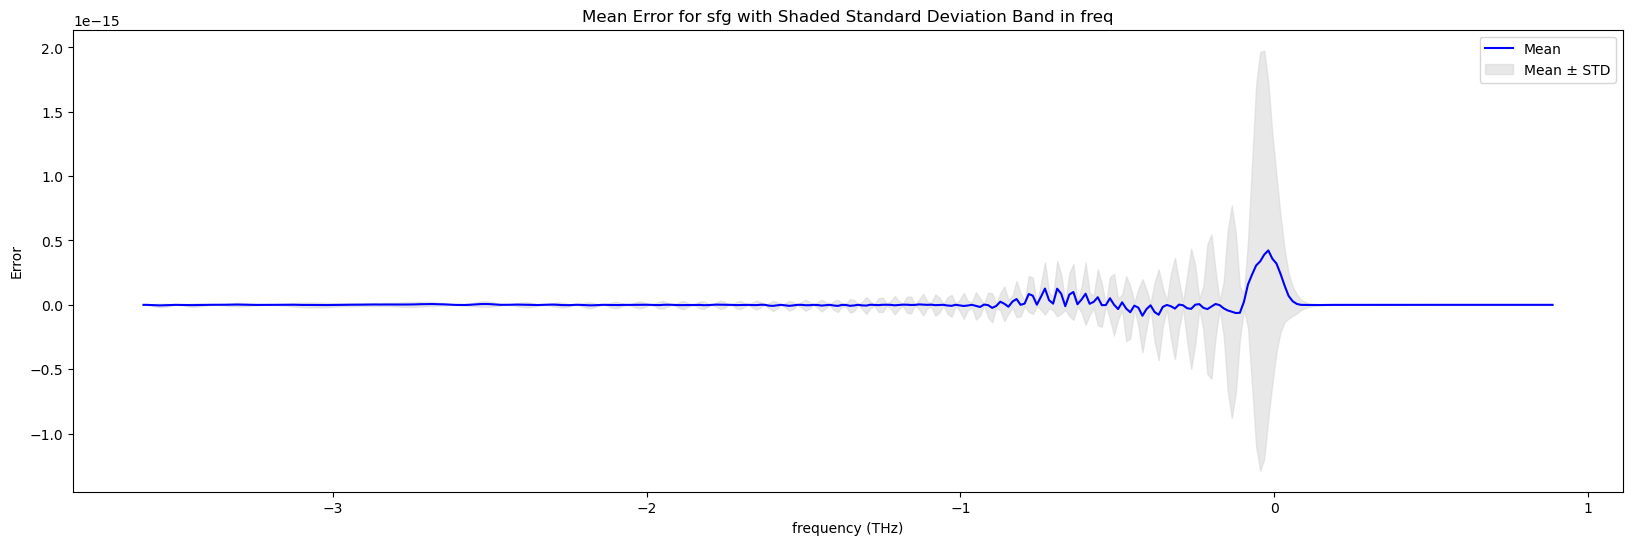

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming sfg_errs is initialized and has shape (90, 32768)

# Compute the mean and standard deviation across the example dimension
SFG_mean_errors = np.mean(sfg_errs, axis=0)
SFG_std_errors = np.std(sfg_errs, axis=0)
    
# Create the plot
plt.figure(figsize=(20, 6))  # Wide figure for better visibility

# NOTE: Uncomment this part to zoom in.
# SFG_mean_errors = SFG_mean_errors[15_000:18_000]
# SFG_std_errors = SFG_std_errors[15_000:18_000]
# x_values = x_values[15_000:18_000]

mean_plus_std = (SFG_mean_errors + SFG_std_errors)
mean_minus_std = (SFG_mean_errors - SFG_std_errors)

# Plot the mean
plt.plot(x_values, SFG_mean_errors, label='Mean', color='blue')

# Create the shaded standard deviation area
plt.fill_between(x_values, mean_minus_std, mean_plus_std, color='lightgray', alpha=0.5, label='Mean ± STD')

# Adding labels and title for clarity
plt.xlabel(x_label)
plt.ylabel('Error')
plt.title(f'Mean Error for {which} with Shaded Standard Deviation Band in {domain_type}')
plt.legend()

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_139432/970226061.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x_values, SFG_mean_errors, yerr=SFG_std_errors, fmt='o', ecolor='orangered', capsize=5, linestyle='-', marker='.', color='blue', label='Mean SFG Errors with STD')


<ErrorbarContainer object of 3 artists>

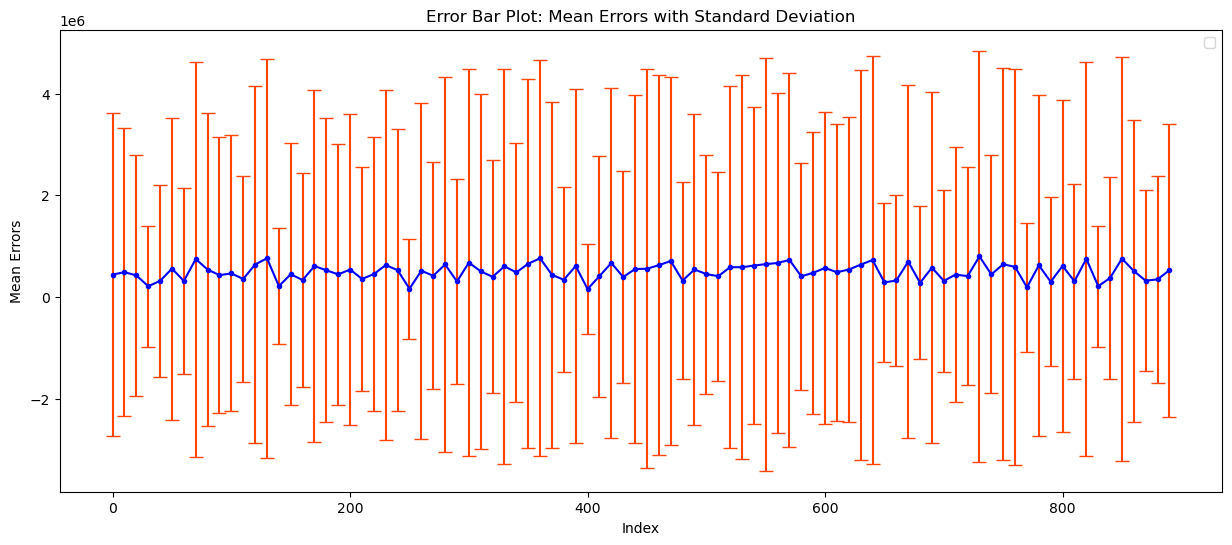

In [28]:
x_values = np.arange(len(SFG_mean_errors)) *10
plt.figure(figsize=(15, 6))
plt.xlabel('Index')
plt.ylabel('Mean Errors')
plt.title('Error Bar Plot: Mean Errors with Standard Deviation')
plt.legend()
plt.errorbar(x_values, SFG_mean_errors, yerr=SFG_std_errors, fmt='o', ecolor='orangered', capsize=5, linestyle='-', marker='.', color='blue', label='Mean SFG Errors with STD')

/tmp/ipykernel_143617/1258885821.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_values[15_000:18_000], SFG_mean_errors[15_000:18_000], yerr=SFG_std_errors[15_000:18_000], fmt='-', ecolor='lightgray', elinewidth=0.5, capsize=0, linestyle='-', color='blue', label='Mean Errors with STD', errorevery=1000)


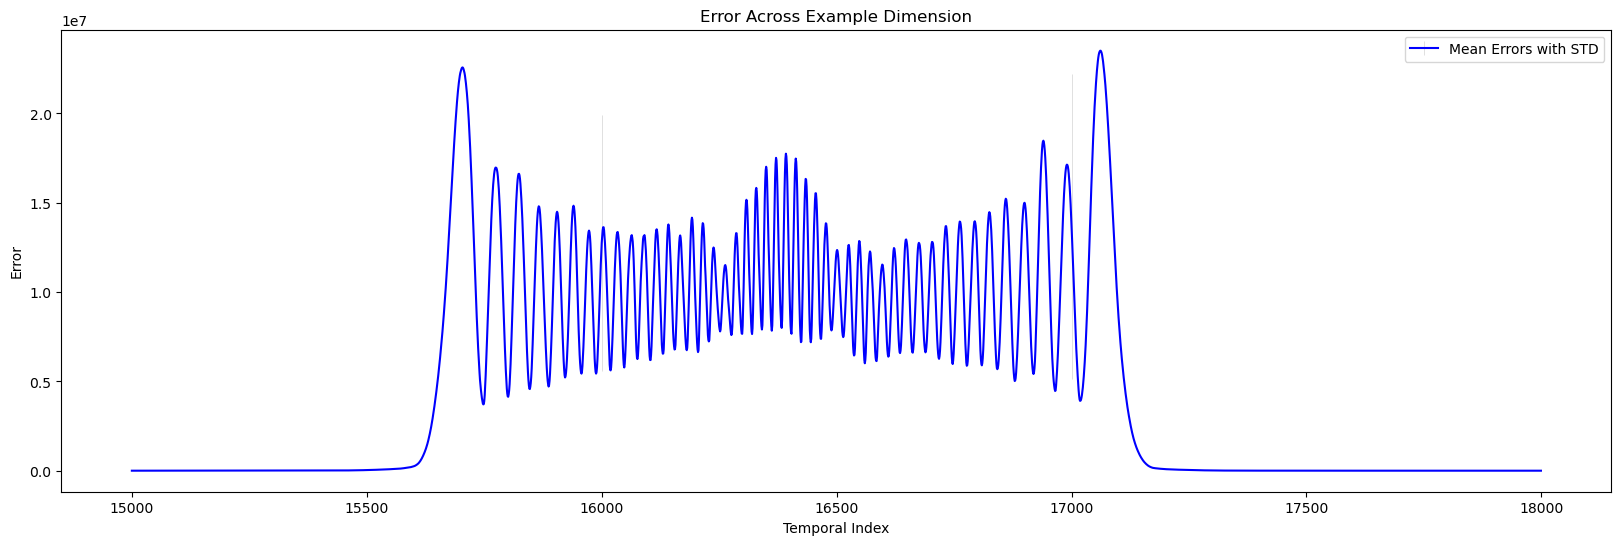

In [8]:
import matplotlib.pyplot as plt

# Assuming sfg_errs is initialized and has shape (90, 32768)

sfg_errs = sfg_errs_copy

# Compute the mean and standard deviation across the example dimension
SFG_mean_errors = np.mean(sfg_errs, axis=0)
SFG_std_errors = np.std(sfg_errs, axis=0)

# X values - range with the length of the temporal dimension
x_values = np.arange(SFG_mean_errors.shape[0])

# Due to the large number of points, consider plotting in a wider format
plt.figure(figsize=(20, 6))  # Adjust the figure size as needed

# Plotting with error bars
# plt.errorbar(x_values, SFG_mean_errors, yerr=SFG_std_errors, fmt='-', ecolor='lightgray', elinewidth=0.5, capsize=0, linestyle='-', color='blue', label='Mean Errors with STD', errorevery=1000)
plt.errorbar(x_values[15_000:18_000], SFG_mean_errors[15_000:18_000], yerr=SFG_std_errors[15_000:18_000], fmt='-', ecolor='lightgray', elinewidth=0.5, capsize=0, linestyle='-', color='blue', label='Mean Errors with STD', errorevery=1000)

# Adding labels and title for clarity
plt.xlabel('Temporal Index')
plt.ylabel('Error')
plt.title('Error Across Example Dimension')
plt.legend()

# Given the large data size, you might want to limit the x-axis or use a more dense error bar representation
# plt.xlim(0, 32768)  # Adjust or remove this line as needed

# Show the plot
# plt.show()
